# Classifying Motor Imagery Using CNN on Topographic EEG Data

This notebook explores the application of Convolutional Neural Networks (CNN) to classify motor imagery tasks from topographic representations of EEG data. We focus on differentiating left and right-hand movements based on brain activity, represented through spatial topographic maps. The use of CNN enables the model to capture intricate spatial patterns from these images, leading to effective classification.


In [1]:
%%capture
!pip install mne
! pip install tensorflow

In [2]:
%%capture
import gc
import mne
import os
import matplotlib.pyplot as plt
import numpy as np
import mne
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from mne.decoding import CSP


from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf

# Set the random seed for NumPy
np.random.seed(42)

In [3]:
#call in data
file_path = "/content/drive/MyDrive/0000_thesis_msc_mental_workload/000_data_MI_27giga_folder/all_zip/topo_maps10k_0to125.npy"
topo_maps = np.load(file_path)
file_path_y = "/content/drive/MyDrive/0000_thesis_msc_mental_workload/000_data_MI_27giga_folder/all_zip/y.npy"
y = np.load(file_path_y)

In [4]:
#safety copy
topo_maps_original_np = topo_maps

In [17]:
topo_maps.shape

(10000, 224, 224, 3)

## Loading and Preprocessing of Topographic EEG Data

In this section, we load the preprocessed topographic EEG data(see preprocessing notebook). The data is represented as 2D spatial maps created from EEG signals by the 'mne' package, visualizing brain activity during motor imagery tasks with colors. These topographic images are resized and normalized to fit the input requirements of the CNN model.


In [5]:
#preprocess



from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
#from tensorflow.keras.utils import to_categorical

# 'topo_maps' are your EEG images and 'labels' are the class labels

# # Normalize the data
# scaler = MinMaxScaler()
# topo_maps = scaler.fit_transform(topo_maps)

# Normalize the data
topo_maps_for_X = topo_maps.astype('float32') / 255.0

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(topo_maps_for_X, y[:10000], test_size=0.2, random_state=42)


## CNN Model for Topographic Brain Activity Classification

The CNN architecture used in this notebook is designed to process the topographic EEG images. CNN layers are effective in detecting spatial features from the 2D EEG maps, such as regions of high brain activity related to motor imagery tasks.

In [ ]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

In [13]:
from sklearn.metrics import classification_report
import numpy as np


y_pred_probs = model.predict(X_test)

# Convert probabilities to class labels
# binary classification, threshold at 0.5
y_pred = np.where(y_pred_probs > 0.5, 1, 0)

report = classification_report(y_test, y_pred, target_names=["Left hand", "Right hand"])

print(report)


63/63 [==============================] - 5s 70ms/step
              precision    recall  f1-score   support

   Left hand       0.69      0.68      0.69       995
  Right hand       0.69      0.70      0.70      1005

    accuracy                           0.69      2000
   macro avg       0.69      0.69      0.69      2000
weighted avg       0.69      0.69      0.69      2000



## Results and Grad-CAM Interpretation

After training the CNN, we evaluate its performance using various metrics like accuracy, precision, and recall. Additionally, we use **Gradient-weighted Class Activation Mapping (Grad-CAM)** to visualize which regions of the EEG topographic images the CNN is focusing on when making predictions.

### Classification Performance:
- Overall accuracy on topographic data: 72%
- **Precision/Recall**: Balanced performance across both left and right-hand motor imagery classes.
- **Confusion Matrix**: Visualize the classification errors between the two classes.

### Grad-CAM Visualization:
- The Grad-CAM heatmap highlights the regions in the brain most relevant to the CNN’s decision-making process, allowing us to interpret the spatial patterns that contribute to classification accuracy.


Visualize a single topomap's feature maps at seperate points to develop an understanding of the CNN's workings. 

1/1 [==============================] - 0s 54ms/step


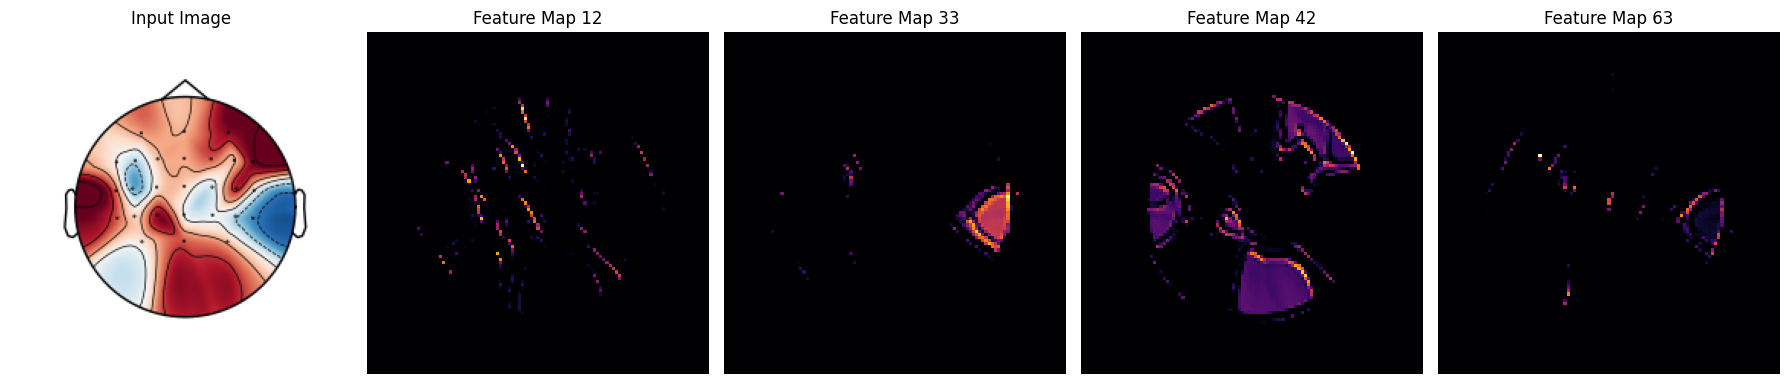

Layer index 5 is not a convolutional layer. Skipping...


In [21]:
def summarized_feature_maps(model, input_image, layer_indices=[2], num_maps=4):
    for layer_index in layer_indices:
        # Check if the layer index is valid
        if layer_index >= len(model.layers):
            print(f"Layer index {layer_index} is out of bounds. Skipping...")
            continue

        # Check if the layer is a convolutional layer
        if not isinstance(model.layers[layer_index], (tf.keras.layers.Conv2D, tf.keras.layers.Conv1D)):
            print(f"Layer index {layer_index} is not a convolutional layer. Skipping...")
            continue

        # Extract feature maps
        feature_model = tf.keras.Model(inputs=model.inputs, outputs=model.layers[layer_index].output)
        feature_maps = feature_model.predict(np.expand_dims(input_image, axis=0))

        # Number of feature maps in the current layer
        num_features = feature_maps.shape[-1]

        # Hardcoded indices of the feature maps we want to display
      #  selected_indices = [5, 10, 15, 20]
        selected_indices = [12, 33, 42, 63]
        # Ensure the hardcoded indices are valid
        selected_indices = [idx for idx in selected_indices if idx < num_features]

        # Plot original topomap and selected feature maps
        fig, axes = plt.subplots(1, len(selected_indices) + 1, figsize=(18, 18))  # +1 for the original topomap

        # Display original topomap
        axes[0].imshow(input_image, cmap='viridis')
        axes[0].axis('off')
        axes[0].set_title('Input Image')

        # Display feature maps
        for i, idx in enumerate(selected_indices):
            axes[i+1].imshow(feature_maps[0, :, :, idx], cmap='inferno')  # i+1 to skip the first subplot
            axes[i+1].axis('off')
            axes[i+1].set_title(f"Feature Map {idx}")

        plt.tight_layout()
        plt.show()

# Use the function to visualize the feature maps
sample_image = X_test[0]  # replace with an appropriate sample image
summarized_feature_maps(model, sample_image, layer_indices=[2, 5], num_maps=4)


63/63 [==============================] - 4s 63ms/step


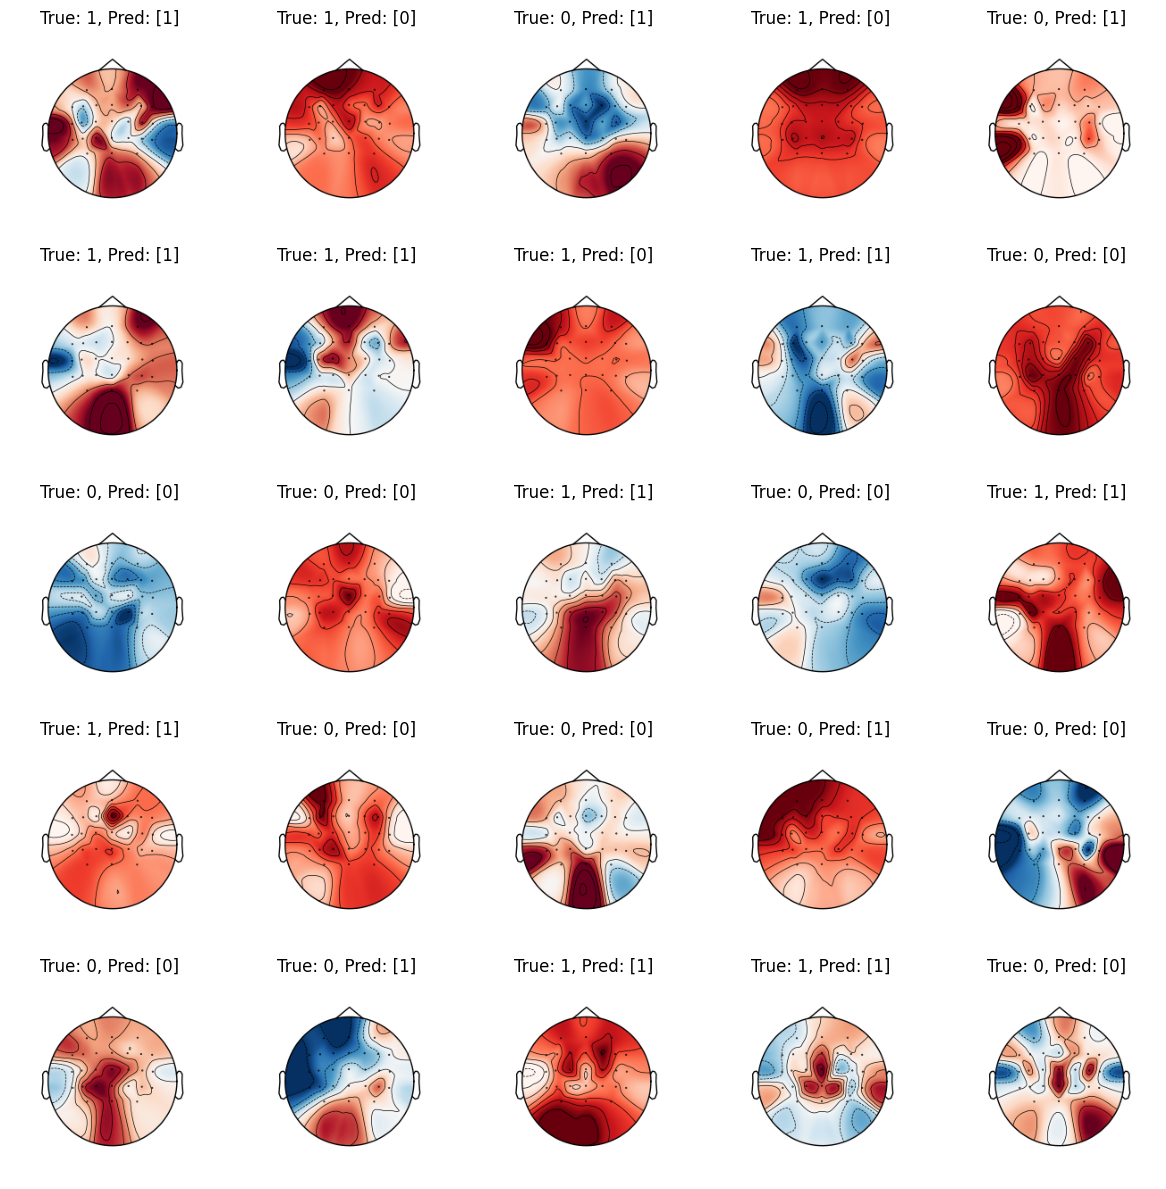

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Get predictions
predictions = model.predict(X_test)
predictions = np.round(predictions).astype(int)

# Plot some test images with their predictions
fig, axes = plt.subplots(5, 5, figsize=(12, 12))

for i, ax in enumerate(axes.flat):
    ax.imshow(X_test[i])
    ax.set_title(f"True: {y_test[i]}, Pred: {predictions[i]}")
    ax.axis('off')

plt.tight_layout()
plt.show()


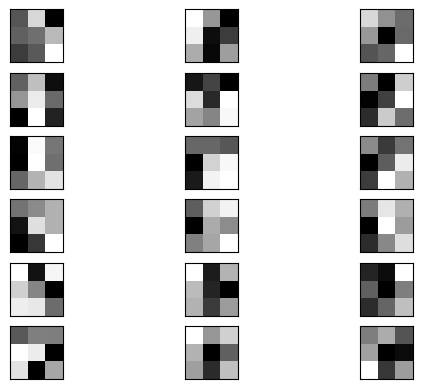

In [ ]:
# Extract the weights from the first convolutional layer
filters, biases = model.layers[0].get_weights()

# Normalize filter values to range 0-1
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

# Plot the first few filters
n_filters, idx = 6, 1
for i in range(n_filters):
    # Get the filter
    f = filters[:, :, :, i]

    # Plot each channel separately
    for j in range(3):  # assuming you're using RGB images
        ax = plt.subplot(n_filters, 3, idx)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(f[:, :, j], cmap='gray')
        idx += 1

plt.show()


In [ ]:
def plot_feature_maps(model, layer_index, input_image):
    # Create a Model with the input layer and desired output layer
    feature_model = tf.keras.Model(inputs=model.inputs, outputs=model.layers[layer_index].output)
    feature_maps = feature_model.predict(np.expand_dims(input_image, axis=0))

    # Plot the feature maps
    num_features = feature_maps.shape[-1]
    square = int(np.sqrt(num_features))

    fig, axes = plt.subplots(square, square, figsize=(12, 12))

    for i, ax in enumerate(axes.flat):
        if i < num_features:
            ax.imshow(feature_maps[0, :, :, i], cmap='viridis')
            ax.axis('off')

    plt.tight_layout()
    plt.show()

# Use the function to visualize the feature maps
sample_image = X_test[0]  # replace with an appropriate sample image
plot_feature_maps(model, 2, sample_image)  # Here, '2' refers to the index of the second convolutional layer


In [ ]:
def display_feature_maps_for_labels(model, X_test, y_test, true_label, predicted_label, layer_index, num_images=10):
    # Get the model's predictions for the test set
    predictions = np.round(model.predict(X_test)).astype(int).flatten()

    # Filter images based on the chosen true and predicted labels
    mask = np.logical_and(y_test == true_label, predictions == predicted_label)
    filtered_images = X_test[mask]

    # Ensure we don't exceed the number of available filtered images
    images_to_display = min(num_images, len(filtered_images))

    # Display feature maps for the filtered images
    for idx in range(images_to_display):
        sample_image = filtered_images[idx]
        plot_feature_maps(model, layer_index, sample_image)

display_feature_maps_for_labels(model, X_test, y_test, true_label=0, predicted_label=1, layer_index=2, num_images=2)


1/1 [==============================] - 0s 56ms/step


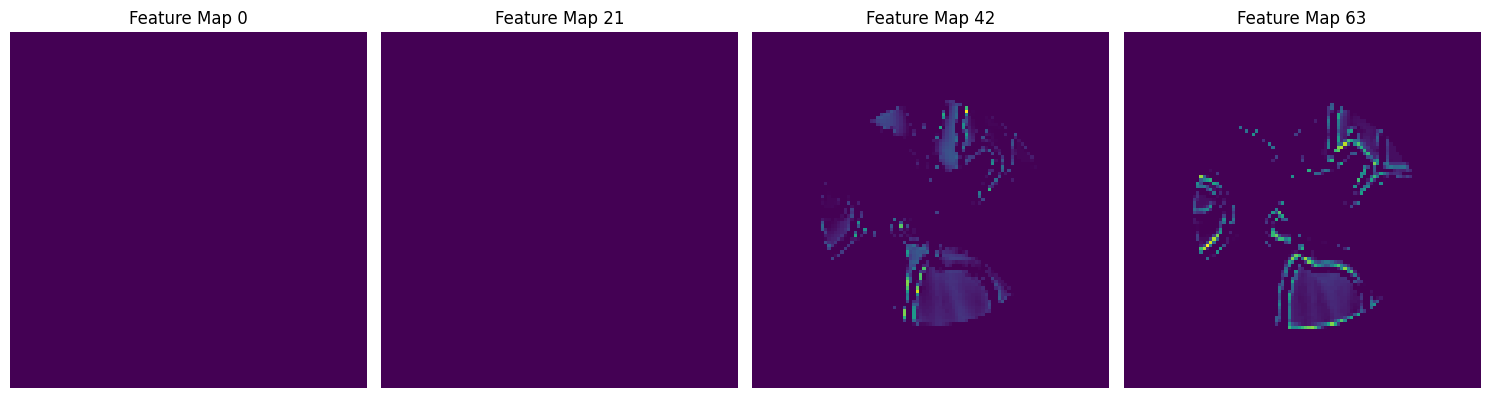

Layer index 5 is not a convolutional layer. Skipping...


In [ ]:
def summarized_feature_maps(model, input_image, layer_indices=[2], num_maps=4):
    for layer_index in layer_indices:
        # Check if the layer index is valid
        if layer_index >= len(model.layers):
            print(f"Layer index {layer_index} is out of bounds. Skipping...")
            continue

        # Check if the layer is a convolutional layer
        if not isinstance(model.layers[layer_index], (tf.keras.layers.Conv2D, tf.keras.layers.Conv1D)):
            print(f"Layer index {layer_index} is not a convolutional layer. Skipping...")
            continue

        # Extract feature maps
        feature_model = tf.keras.Model(inputs=model.inputs, outputs=model.layers[layer_index].output)
        feature_maps = feature_model.predict(np.expand_dims(input_image, axis=0))

        # Number of feature maps in the current layer
        num_features = feature_maps.shape[-1]

        # Select a subset of feature maps (either randomly or based on some criterion)
        selected_indices = np.linspace(0, num_features-1, num_maps).astype(int)

        # Plot selected feature maps
        fig, axes = plt.subplots(1, num_maps, figsize=(15, 15))
        for i, idx in enumerate(selected_indices):
            axes[i].imshow(feature_maps[0, :, :, idx], cmap='viridis')
            axes[i].axis('off')
            axes[i].set_title(f"Feature Map {idx}")

        plt.tight_layout()
        plt.show()

# Use the function to visualize the feature maps
sample_image = X_test[0]  # replace with an appropriate sample image
summarized_feature_maps(model, sample_image, layer_indices=[2, 5], num_maps=4)


1/1 [==============================] - 0s 55ms/step


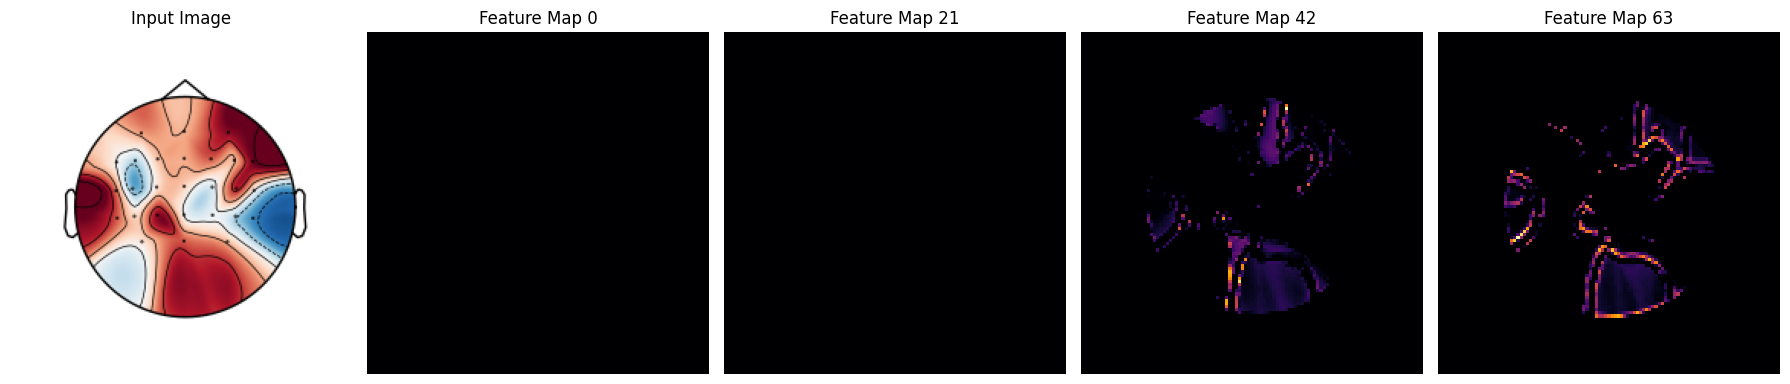

Layer index 5 is not a convolutional layer. Skipping...


In [ ]:
def summarized_feature_maps(model, input_image, layer_indices=[2], num_maps=4):
    for layer_index in layer_indices:
        # Check if the layer index is valid
        if layer_index >= len(model.layers):
            print(f"Layer index {layer_index} is out of bounds. Skipping...")
            continue

        # Check if the layer is a convolutional layer
        if not isinstance(model.layers[layer_index], (tf.keras.layers.Conv2D, tf.keras.layers.Conv1D)):
            print(f"Layer index {layer_index} is not a convolutional layer. Skipping...")
            continue

        # Extract feature maps
        feature_model = tf.keras.Model(inputs=model.inputs, outputs=model.layers[layer_index].output)
        feature_maps = feature_model.predict(np.expand_dims(input_image, axis=0))

        # Number of feature maps in the current layer
        num_features = feature_maps.shape[-1]

        # Select a subset of feature maps
        selected_indices = np.linspace(0, num_features-1, num_maps).astype(int)

        # Plot original topomap and selected feature maps
        fig, axes = plt.subplots(1, num_maps + 1, figsize=(18, 18))  # +1 for the original topomap

        # Display original topomap
        axes[0].imshow(input_image, cmap='viridis')
        axes[0].axis('off')
        axes[0].set_title('Input Image')

        # Display feature maps
        for i, idx in enumerate(selected_indices):
            axes[i+1].imshow(feature_maps[0, :, :, idx], cmap='inferno')  # i+1 to skip the first subplot
            axes[i+1].axis('off')
            axes[i+1].set_title(f"Feature Map {idx}")

        plt.tight_layout()
        plt.show()

# Use the function to visualize the feature maps
sample_image = X_test[0]  # replace with an appropriate sample image
summarized_feature_maps(model, sample_image, layer_indices=[2, 5], num_maps=4)


In [ ]:
# Check the model's prediction for the given topomap
sample_image = X_test[0]
predicted_prob = model.predict(np.expand_dims(sample_image, axis=0))
predicted_label = int(np.round(predicted_prob[0][0]))
print(f"Predicted probability: {predicted_prob[0][0]}")
print(f"Predicted label: {predicted_label}")


1/1 [==============================] - 0s 31ms/step
Predicted probability: 0.9194412231445312
Predicted label: 1


## Grad-CAM Visualization:
- The Grad-CAM heatmap highlights the regions in the brain most relevant to the CNN’s decision-making process, allowing us to interpret the spatial patterns that contribute to classification accuracy.

In [ ]:
def compute_gradcam(model, img, class_index, layer_name):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(layer_name).output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(np.array([img]))

        # Adjusting for binary classification
        if class_index == 1:
            loss = predictions[:, 0]
        else:
            loss = 1 - predictions[:, 0]

    output = conv_outputs[0]
    grads = tape.gradient(loss, conv_outputs)[0]

    gate_f = tf.cast(output > 0, 'float32')
    gate_r = tf.cast(grads > 0, 'float32')
    guided_grads = gate_f * gate_r * grads

    weights = tf.reduce_mean(guided_grads, axis=(0, 1))
    cam = np.ones(output.shape[0:2], dtype=np.float32)

    for i, w in enumerate(weights):
        cam += w * output[:, :, i]

    cam = cv2.resize(cam.numpy(), (224, 224))
    cam = np.maximum(cam, 0)
    heatmap = (cam - cam.min()) / (cam.max() - cam.min())

    cam = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_INFERNO) #Parula INFERNO
    output_image = cv2.addWeighted(cv2.cvtColor(img.astype('uint8'), cv2.COLOR_RGB2BGR), 0.5, cam, 1, 0)

    return output_image

## Grad-CAM Interpretation
Each list of figures represents one of the 4 sections of the confusion matrix. 

From the figures, it is clear that there is significant variability in the classification importances across regions. This variability indicates that the CNN is detecting features that are difficult to distinguish with the human eye. Larger regions of importance are colored red, with brightness correlating to the significance of that region in the CNN’s classification. Interestingly, the bright blue contours around these regions suggest that the CNN prioritizes the contours rather than focusing solely on the surface areas of higher importance.
Earlier layers typically focus on lower-level features such as edges or textures, while deeper layers are expected to capture higher-level features. 


63/63 [==============================] - 4s 64ms/step


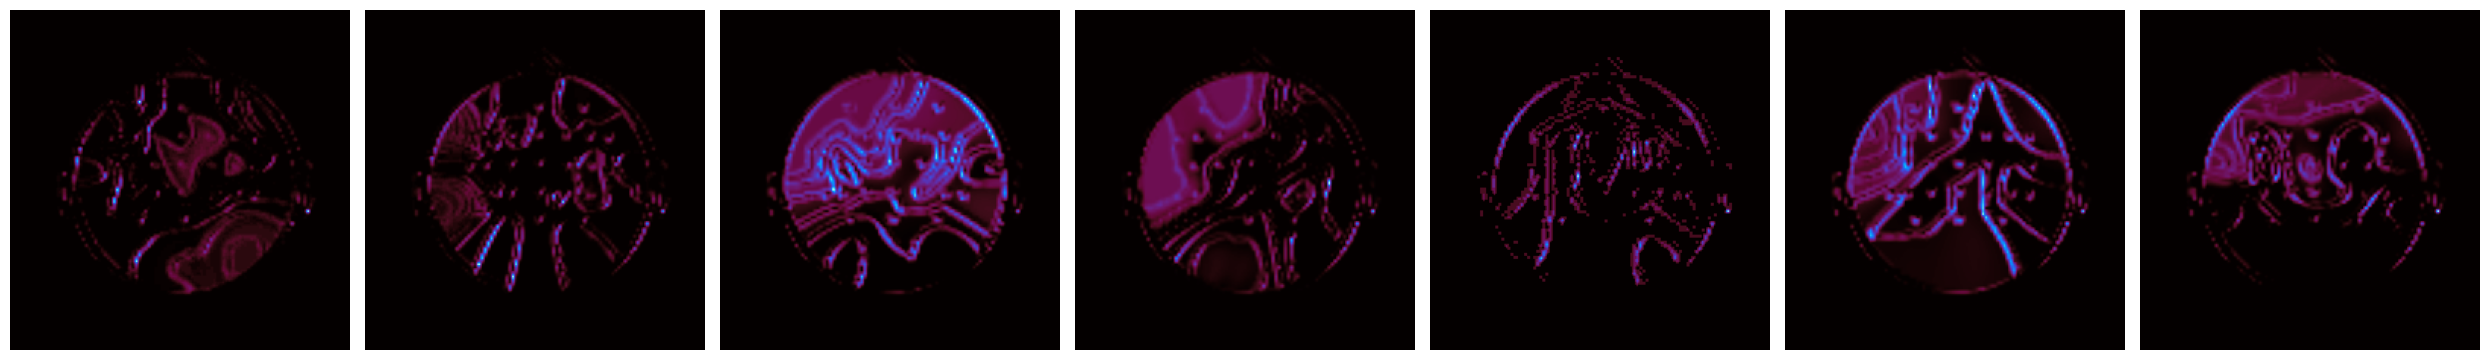

In [ ]:
def display_gradcam_for_labels(model, X_test, y_test, true_label, predicted_label, num_images=10):
    fig, axes = plt.subplots(1, num_images, figsize=(25, 5))

    # Get the model's predictions for the test set
    predictions = np.round(model.predict(X_test)).astype(int).flatten()

    # Filter images based on the chosen true and predicted labels
    mask = np.logical_and(y_test == true_label, predictions == predicted_label)
    filtered_images = X_test[mask]

    # Display Grad-CAM for the filtered images
    for idx, ax in enumerate(axes):
        if idx < len(filtered_images):  # Ensure there's an image to display
            sample_image = filtered_images[idx]
            gradcam_image = compute_gradcam(model, sample_image, predicted_label, "conv2d_1")

            ax.imshow(gradcam_image)
            ax.axis('off')
            #ax.set_title(f"True: {true_label}, Predicted: {predicted_label}")
        else:
            ax.axis('off')  # If no more images to display, just hide the axis

    plt.tight_layout()
    plt.show()

# Example usage:
display_gradcam_for_labels(model, X_test, y_test, true_label=0, predicted_label=1, num_images=7)


63/63 [==============================] - 4s 65ms/step


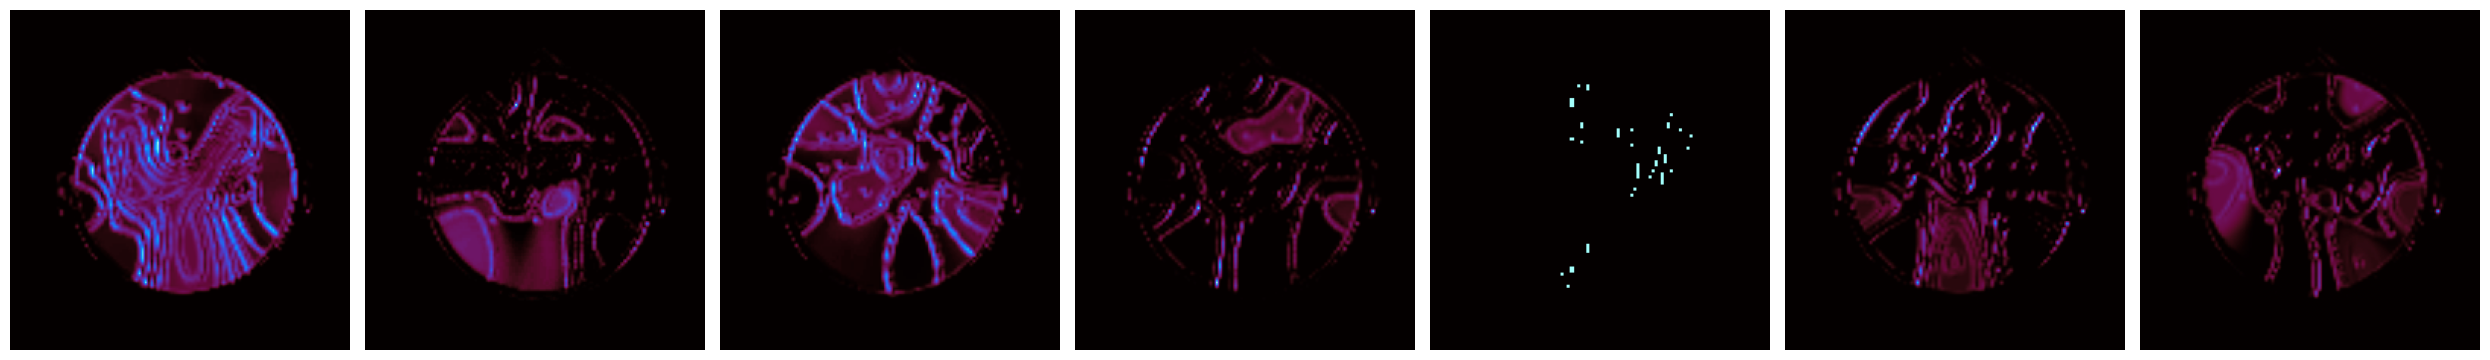

In [ ]:

display_gradcam_for_labels(model, X_test, y_test, true_label=0, predicted_label=0, num_images=7)


63/63 [==============================] - 4s 66ms/step


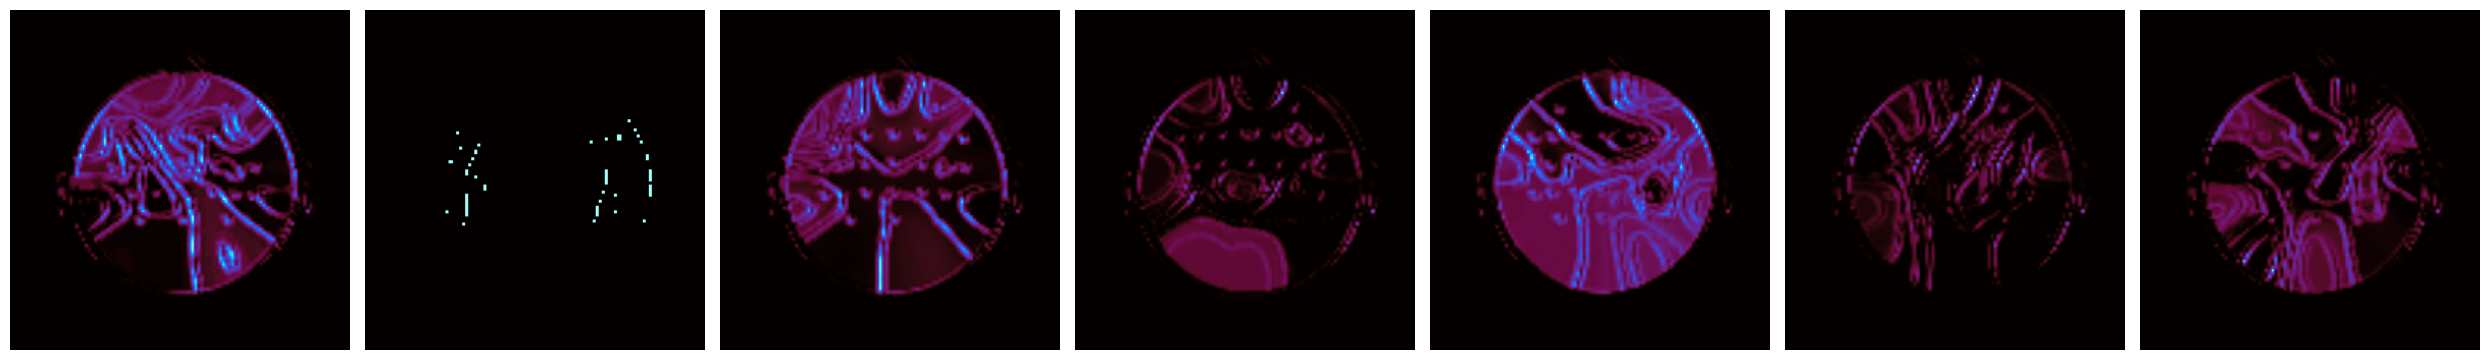

In [ ]:

display_gradcam_for_labels(model, X_test, y_test, true_label=1, predicted_label=0, num_images=7)


In [ ]:

display_gradcam_for_labels(model, X_test, y_test, true_label=1, predicted_label=1, num_images=7)
